# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [1]:
import numpy as np
import h5py
import random
import keras
from keras.models import Model
from keras.layers import Input, Dense, InputLayer, Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import HDF5Matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc


#Loading the data

#RVSFlux
normrvs = 'norm_rvsflux.h5'
readnorm = h5py.File(normrvs, 'r')
print(readnorm.keys())
norm_flux = readnorm.get('normrvs')
norm_flux = np.array(norm_flux)
readnorm.close()

#LogTeff
modparam = 'modparam_feh0.h5' #model parameters
readfile = h5py.File(modparam, 'r')
print(readfile.keys())
logg = readfile.get('logg')
logg = np.array(logg)
readfile.close()


print('The shapes of features and labels:', np.shape(norm_flux), np.shape(logg))









Using TensorFlow backend.


<KeysViewHDF5 ['normrvs']>
<KeysViewHDF5 ['logg', 'teff']>
The shapes of features and labels: (415, 1134) (415,)


total number of input stars = 415
number of training data= 336
the size of cvs= (79, 1134) (79,)


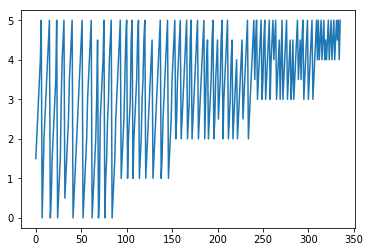

In [2]:

#features
num_tot = len(logg)
print('total number of input stars =', num_tot)
plim = 0.8
ran_frac = np.random.uniform(0,1,num_tot)
#print('ranfrac=' , ran_frac)
x_train = norm_flux[ran_frac < plim, :]
print('number of training data=', len(x_train[:,0]))
x_cv= norm_flux[ran_frac >= plim, :] #test set we left for the application



#output label
y_train = logg[ran_frac< plim]
y_cv = logg[ran_frac >= plim] #test set
print('the size of cvs=',np.shape(x_cv), np.shape(y_cv) )

id = np.linspace(0, len(x_train[:, 0])-1, len(x_train[:, 0]))
plt.plot(id, y_train)
plt.show()



** Normalization **

Write a function to normalize the output labels. Each label will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units

In [3]:
mean_labels=np.mean(logg)
std_labels=np.std(logg)
print('mean and std teff=', mean_labels, std_labels)
def normalize(labels):
    # Normalize labels
    return (labels-mean_labels) / std_labels





mean and std teff= 3.2903614457831325 1.3445664377417443


In [4]:
#normalize the y labels 
#print('y train before norm=', y_train )
y_train= normalize(y_train)
y_cv= normalize(y_cv)
#print('y train after norm=', y_train )

**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

In [5]:
# activation function used following every layer except for the output layers
activation = 'relu'
#activation = 'sigmoid'

# model weight initializer
initializer = 'he_normal'

# number of filters used in the convolutional layers
#num_filters = [4,16]
num_filters = [8,32]
#num_filters = [8,16]

# length of the filters in the convolutional layers
#filter_length = 8
#filter_length = 16
filter_length = 8

# length of the maxpooling window 
pool_length = 4

# number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]
#num_hidden = [24,12]

# number of spectra fed into model at once during training
batch_size = 64

# maximum number of interations for model training
#max_epochs = 200
#max_epochs = 100
#max_epochs = 150 
#max_epochs = 350
#max_epochs = 225
#max_epochs = 180
#max_epochs = 450
#max_epochs = 300
max_epochs = 150


# initial learning rate for optimization algorithm
lr = 0.000003 #handled by Adam
    
# exponential decay rate for the 1st moment estimates for optimization algorithm
beta_1 = 0.9

# exponential decay rate for the 2nd moment estimates for optimization algorithm
beta_2 = 0.999

# a small constant for numerical stability for optimization algorithm
optimizer_epsilon = 1e-08

number of training fluxes= 1134
number of training teff= 1


[]

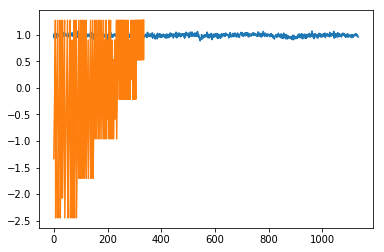

In [6]:
num_fluxes=len(x_train[0,:]) 
print('number of training fluxes=', num_fluxes)

num_labels= 1
print('number of training teff=', num_labels)

ilam = np.linspace(0, num_fluxes-1, num_fluxes)
plt.plot(ilam, x_train[329, :])
plt.plot()

iy = np.linspace(0, len(y_train)-1, len(y_train))
plt.plot(iy, y_train)
plt.plot()

In [7]:

# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_in) #first CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_in) #2nd CNN layer

# Max pooling layer
cur_in = MaxPooling1D(pool_size=pool_length)(cur_in)

# Flatten the current input for the fully-connected layers
cur_in = Flatten()(cur_in)
print(np.shape(cur_in))

# Fully-connected layers
cur_in = Dense(units=num_hidden[0], kernel_initializer=initializer, 
               activation=activation)(cur_in)
cur_in = Dense(units=num_hidden[1], kernel_initializer=initializer, 
               activation=activation)(cur_in)



# Output nodes
output_label = Dense(units=num_labels, activation="linear", 
                     input_dim=num_hidden[1], name='starnet_output_y')(cur_in)

model = Model(input_spec, output_label, name='StarNet')

Instructions for updating:
Colocations handled automatically by placer.
(?, ?)


**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [8]:
# Default loss function parameters
early_stopping_min_delta = 0.0007
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.0000009
reduce_lr_patience = 2
reduce_lr_min = 0.00008

# loss function to minimize
loss_function = 'mean_squared_error'

# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']

In [9]:
#optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
optimizer = Adam(lr=0.005 )

early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


**Compile model**

In [10]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 1134)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1134, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1134, 8)           72        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1134, 32)          2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 283, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2318592   
__________

**Train model**

In [11]:

#history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
          #epochs=max_epochs, verbose=1, shuffle='batch',
         #callbacks=[early_stopping, reduce_lr])

history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
          epochs=max_epochs, verbose=1, shuffle='batch')

Instructions for updating:
Use tf.cast instead.
Train on 336 samples, validate on 79 samples
Epoch 1/150
336/336 [==============================] - 1s 4ms/step - loss: 512.6611 - mean_absolute_error: 11.7359 - mean_squared_error: 512.6611 - val_loss: 1.0810 - val_mean_absolute_error: 0.8270 - val_mean_squared_error: 1.0810
Epoch 2/150
336/336 [==============================] - 0s 1ms/step - loss: 4.9023 - mean_absolute_error: 1.8489 - mean_squared_error: 4.9023 - val_loss: 1.2018 - val_mean_absolute_error: 0.8527 - val_mean_squared_error: 1.2018
Epoch 3/150
336/336 [==============================] - 0s 1ms/step - loss: 2.1971 - mean_absolute_error: 1.1919 - mean_squared_error: 2.1971 - val_loss: 1.4365 - val_mean_absolute_error: 1.0311 - val_mean_squared_error: 1.4365
Epoch 4/150
336/336 [==============================] - 0s 1ms/step - loss: 1.7264 - mean_absolute_error: 1.0351 - mean_squared_error: 1.7264 - val_loss: 1.2754 - val_mean_absolute_error: 0.9656 - val_mean_squared_error: 1

336/336 [==============================] - 0s 969us/step - loss: 0.3841 - mean_absolute_error: 0.5040 - mean_squared_error: 0.3841 - val_loss: 0.3604 - val_mean_absolute_error: 0.4911 - val_mean_squared_error: 0.3604
Epoch 36/150
336/336 [==============================] - 0s 984us/step - loss: 0.3343 - mean_absolute_error: 0.4661 - mean_squared_error: 0.3343 - val_loss: 0.3422 - val_mean_absolute_error: 0.4787 - val_mean_squared_error: 0.3422
Epoch 37/150
336/336 [==============================] - 0s 978us/step - loss: 0.4057 - mean_absolute_error: 0.4983 - mean_squared_error: 0.4057 - val_loss: 0.5355 - val_mean_absolute_error: 0.6021 - val_mean_squared_error: 0.5355
Epoch 38/150
336/336 [==============================] - 0s 995us/step - loss: 0.4353 - mean_absolute_error: 0.5504 - mean_squared_error: 0.4353 - val_loss: 0.8671 - val_mean_absolute_error: 0.7781 - val_mean_squared_error: 0.8671
Epoch 39/150
336/336 [==============================] - 0s 984us/step - loss: 0.4365 - mean_a

Epoch 71/150
336/336 [==============================] - 0s 993us/step - loss: 0.1175 - mean_absolute_error: 0.2655 - mean_squared_error: 0.1175 - val_loss: 0.1426 - val_mean_absolute_error: 0.2892 - val_mean_squared_error: 0.1426
Epoch 72/150
336/336 [==============================] - 0s 986us/step - loss: 0.1211 - mean_absolute_error: 0.2797 - mean_squared_error: 0.1211 - val_loss: 0.1185 - val_mean_absolute_error: 0.2749 - val_mean_squared_error: 0.1185
Epoch 73/150
336/336 [==============================] - 0s 994us/step - loss: 0.1193 - mean_absolute_error: 0.2848 - mean_squared_error: 0.1193 - val_loss: 0.1221 - val_mean_absolute_error: 0.2695 - val_mean_squared_error: 0.1221
Epoch 74/150
336/336 [==============================] - 0s 988us/step - loss: 0.0965 - mean_absolute_error: 0.2373 - mean_squared_error: 0.0965 - val_loss: 0.1119 - val_mean_absolute_error: 0.2618 - val_mean_squared_error: 0.1119
Epoch 75/150
336/336 [==============================] - 0s 1ms/step - loss: 0.13

Epoch 107/150
336/336 [==============================] - 0s 991us/step - loss: 0.0541 - mean_absolute_error: 0.1820 - mean_squared_error: 0.0541 - val_loss: 0.0707 - val_mean_absolute_error: 0.2102 - val_mean_squared_error: 0.0707
Epoch 108/150
336/336 [==============================] - 0s 992us/step - loss: 0.0529 - mean_absolute_error: 0.1835 - mean_squared_error: 0.0529 - val_loss: 0.0695 - val_mean_absolute_error: 0.2069 - val_mean_squared_error: 0.0695
Epoch 109/150
336/336 [==============================] - 0s 995us/step - loss: 0.0602 - mean_absolute_error: 0.1896 - mean_squared_error: 0.0602 - val_loss: 0.0822 - val_mean_absolute_error: 0.2307 - val_mean_squared_error: 0.0822
Epoch 110/150
336/336 [==============================] - 0s 1ms/step - loss: 0.0533 - mean_absolute_error: 0.1819 - mean_squared_error: 0.0533 - val_loss: 0.0819 - val_mean_absolute_error: 0.2307 - val_mean_squared_error: 0.0819
Epoch 111/150
336/336 [==============================] - 0s 993us/step - loss:

336/336 [==============================] - 0s 973us/step - loss: 0.0263 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0263 - val_loss: 0.0557 - val_mean_absolute_error: 0.1827 - val_mean_squared_error: 0.0557
Epoch 143/150
336/336 [==============================] - 0s 975us/step - loss: 0.0258 - mean_absolute_error: 0.1264 - mean_squared_error: 0.0258 - val_loss: 0.0641 - val_mean_absolute_error: 0.2016 - val_mean_squared_error: 0.0641
Epoch 144/150
336/336 [==============================] - 0s 969us/step - loss: 0.0315 - mean_absolute_error: 0.1347 - mean_squared_error: 0.0315 - val_loss: 0.0611 - val_mean_absolute_error: 0.1958 - val_mean_squared_error: 0.0611
Epoch 145/150
336/336 [==============================] - 1s 1ms/step - loss: 0.0588 - mean_absolute_error: 0.1989 - mean_squared_error: 0.0588 - val_loss: 0.0601 - val_mean_absolute_error: 0.1853 - val_mean_squared_error: 0.0601
Epoch 146/150
336/336 [==============================] - 0s 974us/step - loss: 0.0387 - mean

In [221]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
145,0.026523,0.129729,0.026523,0.019322,0.107715,0.019322,145
146,0.020708,0.116355,0.020708,0.015450,0.098352,0.015450,146
147,0.019401,0.108401,0.019401,0.014723,0.096041,0.014723,147
148,0.023114,0.122418,0.023114,0.023161,0.115103,0.023161,148
149,0.051861,0.182690,0.051861,0.026886,0.131808,0.026886,149


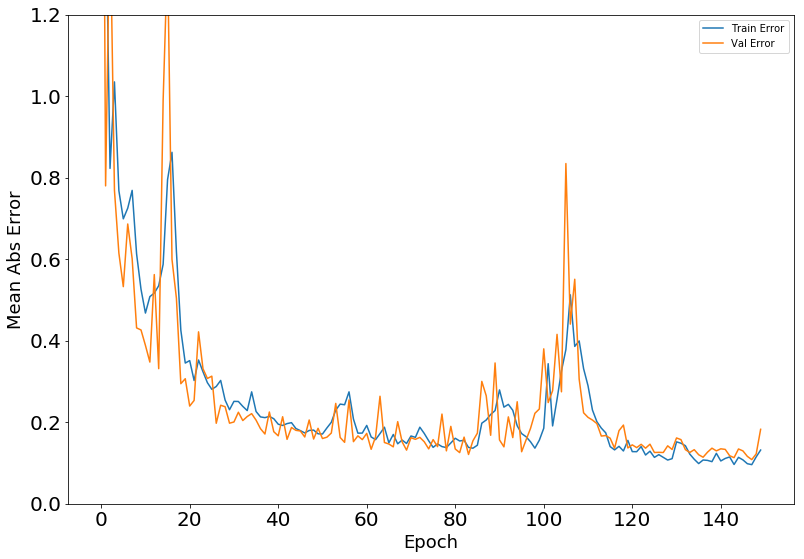

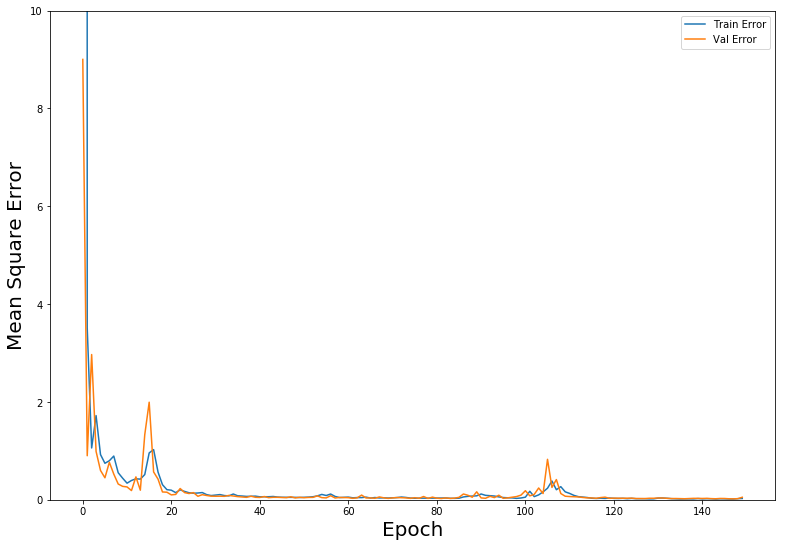

In [222]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize= 18)
  plt.ylabel('Mean Abs Error', fontsize= 18)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.2])
  plt.tick_params(labelsize=20)
  plt.legend()
  

  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Mean Square Error', fontsize= 20)
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

**Save model**

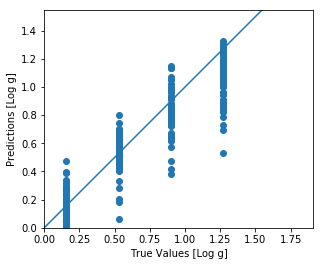

In [12]:
test_predictions = model.predict(norm_flux).flatten()

plt.scatter(normalize(logg), test_predictions)
plt.xlabel('True Values [Log g]')
plt.ylabel('Predictions [Log g]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

#print('test predictions=', test_predictions)

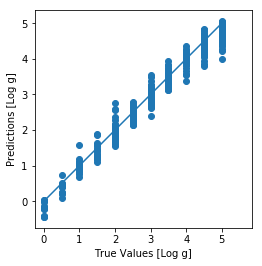

In [13]:
#Unnormalizing the labels (teff)

def denormalize (labels):
    return (((labels)*(std_labels)) + mean_labels)


test_predictions = model.predict(norm_flux).flatten()
plt.scatter(logg, denormalize(test_predictions))
plt.xlabel('True Values [Log g]')
plt.ylabel('Predictions [Log g]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 5 ], [0, 5])

#print('test predictions=', test_predictions)








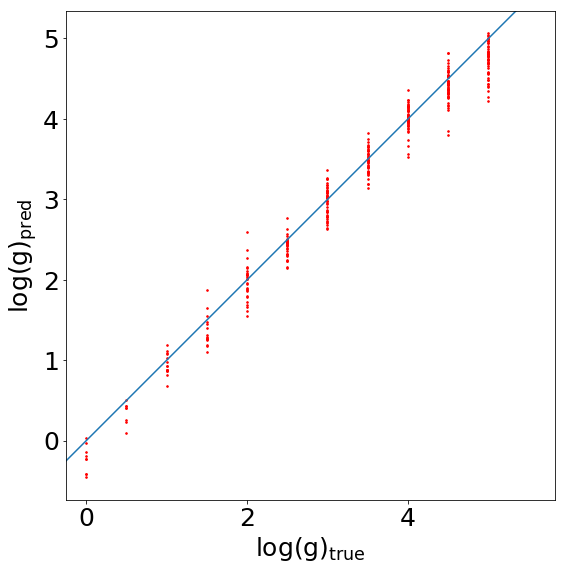

In [14]:
#Unnormalizing the labels (teff)

def denormalize (labels):
    return (((labels)*(std_labels)) + mean_labels)

plt.figure(figsize=(13,9))
test_predictions = model.predict(x_train).flatten()
plt.scatter(denormalize(y_train), denormalize(test_predictions), c= 'r', s= 2.5)
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=25)
plt.ylabel(r"$\rm log(g)_{\rm pred}$", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-0.5, 5.5], [-0.5, 5.5])

#print('test predictions=', test_predictions)

# Training Data Set

In [15]:
# getting deviation in Teff bins
nbin = 3
teffbin_edges=np.array([1, 3, 5])

# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions)
teff_true = denormalize(y_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))



mean of bin teff_true= [0.23529412 2.09285714 4.29057592]
mean of teff_diff= [-0.19174301 -0.07441947 -0.09643187]
std of teff_diff= [0.15261546 0.19328586 0.21359827]
length of teff_diff= 336


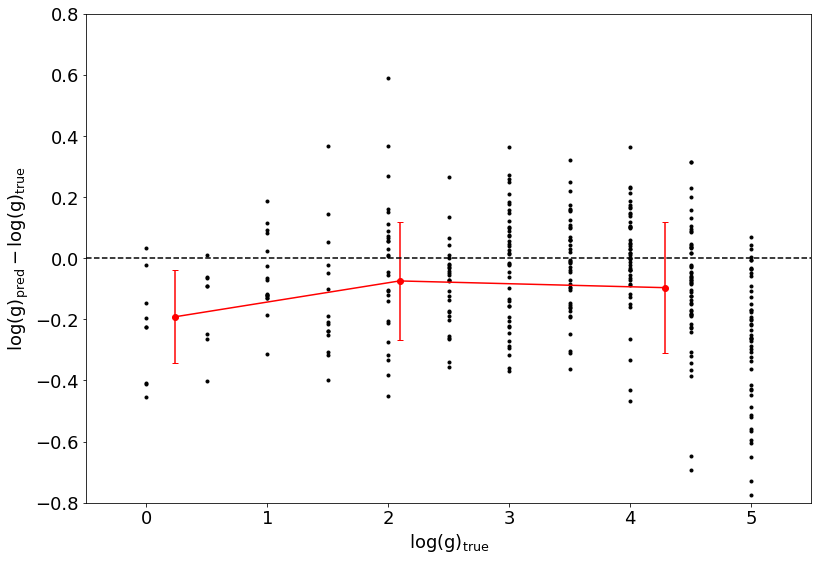

In [16]:
# plot
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.5,5.5])
ylim=np.array([-0.8,0.8])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')




# Cross Validation Set

len of y_cv= 79


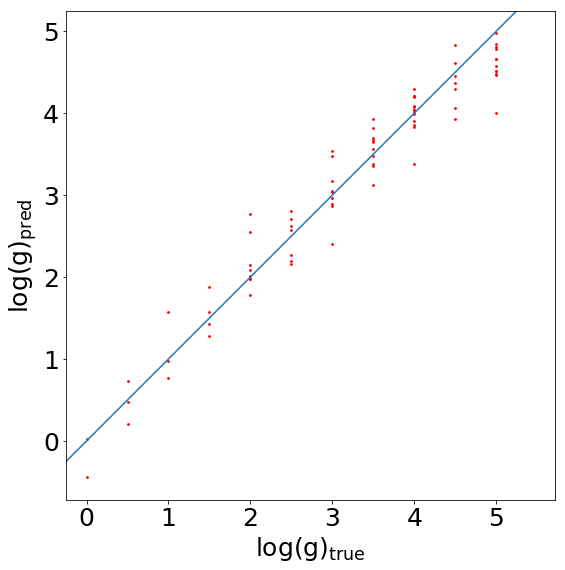

In [17]:
#Test set (x_cv)

plt.figure(figsize=(13,9))
cv_predictions = model.predict(x_cv).flatten()
plt.scatter(denormalize(y_cv), denormalize(cv_predictions), c= 'r', s= 3)
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=25)
plt.ylabel(r"$\rm log(g)_{\rm pred}$", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize=25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-0.5, 5.5], [-0.5, 5.5])

#print('test predictions=', test_predictions)

print('len of y_cv=', len(y_cv))



In [18]:
# getting deviation in Teff bins
nbin = 5
teffbin_edges=np.array([ 1, 2, 3, 4, 5])

# pred vs. true
# unnormalised values
teff_pred = denormalize(cv_predictions)
teff_true = denormalize(y_cv) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('len of teff_diff=', len(teff_diff))

        

mean of bin teff_true= [0.3        1.5        2.5        3.5        4.81578947]
mean of teff_diff= [-0.10259867  0.04298171 -0.02378011  0.06573241 -0.30032992]
std of teff_diff= [0.23880501 0.22020804 0.24235275 0.22555017 0.28664228]
len of teff_diff= 79


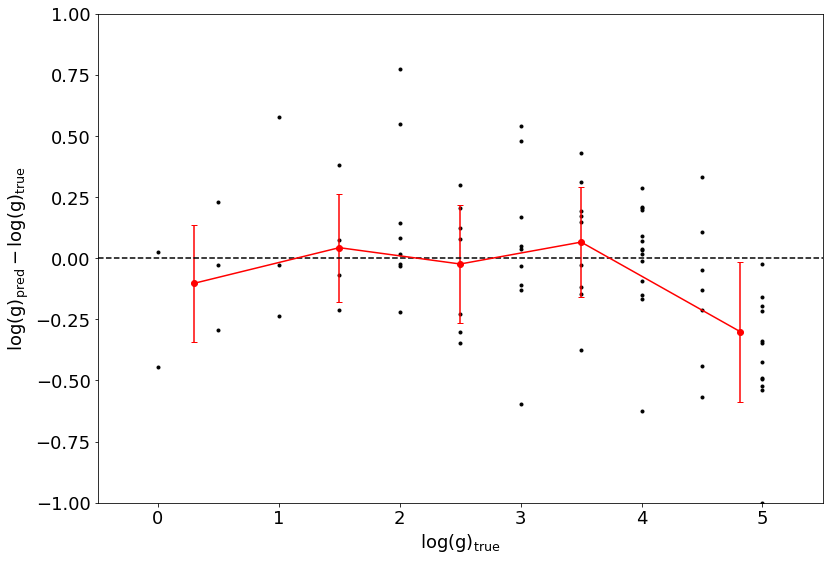

In [19]:
# plot
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm g,true}$ (K)", fontsize=25)
#plt.ylabel(r"$T_{\rm g,pred}-T_{\rm g,true}$ (K)", fontsize=25)

# set x, y lim plot range
xlim=np.array([-0.5, 5.5])
ylim=np.array([-1,1])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')







In [99]:
# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
# First
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=128, kernel_size=32)(cur_in) #first CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=32)(cur_in)
# Second CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=16)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=16)(cur_in)
# Third CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=8)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=8)(cur_in)

# Flatten the current input for the fully-connected layers
cur_in = Flatten()(cur_in)

# Fully-connected layers
cur_in = Dense(units=258, kernel_initializer=initializer, 
               activation=activation)(cur_in)
cur_in = Dense(units=128, kernel_initializer=initializer, 
               activation=activation)(cur_in)

# Output nodes
output_label = Dense(units=num_labels, kernel_regularizer=keras.regularizers.l2(0.01), activation="linear", 
                     input_dim=num_hidden[1])(cur_in)

model = Model(input_spec, output_label)

ValueError: Negative dimension size caused by subtracting 8 from 1 for 'max_pooling1d_12/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,128].

In [16]:
optimizer = Adam(lr=0.0005)

In [97]:
# loss function to minimize
loss_function = 'mean_squared_error'
optimizer = 'adadelta'
# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 6758)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 6758, 1)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6758, 128)         4224      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 211, 128)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 211, 128)          262272    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 13, 128)           131200    
__________

In [ ]:
history = model.fit(x_train, y_train, 
          epochs=max_epochs, validation_split = 0.2, verbose=1, shuffle='batch')

Train on 875 samples, validate on 219 samples
Epoch 1/200
875/875 [==============================] - 13s 15ms/step - loss: 5.2174 - mean_absolute_error: 1.4147 - mean_squared_error: 5.1988 - val_loss: 1.5482 - val_mean_absolute_error: 0.9417 - val_mean_squared_error: 1.5305
Epoch 2/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3955 - mean_absolute_error: 0.5094 - mean_squared_error: 0.3783 - val_loss: 1.8217 - val_mean_absolute_error: 1.0313 - val_mean_squared_error: 1.8050
Epoch 3/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3606 - mean_absolute_error: 0.4579 - mean_squared_error: 0.3443 - val_loss: 1.9750 - val_mean_absolute_error: 1.0742 - val_mean_squared_error: 1.9589
Epoch 4/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3806 - mean_absolute_error: 0.4960 - mean_squared_error: 0.3648 - val_loss: 2.0388 - val_mean_absolute_error: 1.0894 - val_mean_squared_error: 2.0232
Epoch 5/200
875/875 [=================

Epoch 72/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0399 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0361 - val_loss: 1.6221 - val_mean_absolute_error: 0.9613 - val_mean_squared_error: 1.6183
Epoch 73/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0413 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0375 - val_loss: 1.5695 - val_mean_absolute_error: 0.9410 - val_mean_squared_error: 1.5657
Epoch 74/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0508 - mean_absolute_error: 0.1554 - mean_squared_error: 0.0470 - val_loss: 1.6579 - val_mean_absolute_error: 0.9698 - val_mean_squared_error: 1.6541
Epoch 75/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0419 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0381 - val_loss: 1.9499 - val_mean_absolute_error: 1.0596 - val_mean_squared_error: 1.9461
Epoch 76/200
875/875 [==============================] - 12s 14ms/step - loss: 0.

875/875 [==============================] - 12s 13ms/step - loss: 0.0267 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0241 - val_loss: 1.3541 - val_mean_absolute_error: 0.8321 - val_mean_squared_error: 1.3514
Epoch 143/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0540 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0514 - val_loss: 1.8749 - val_mean_absolute_error: 1.0292 - val_mean_squared_error: 1.8723
Epoch 144/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0324 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0298 - val_loss: 1.3159 - val_mean_absolute_error: 0.8185 - val_mean_squared_error: 1.3133
Epoch 145/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0255 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0230 - val_loss: 1.3150 - val_mean_absolute_error: 0.8193 - val_mean_squared_error: 1.3124
Epoch 146/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0254 - me

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
195,6.650632e+07,6355.818481,6.650632e+07,1.702399e+06,881.769361,1.702399e+06,195
196,6.275853e+07,6161.197162,6.275853e+07,1.711892e+06,930.596856,1.711892e+06,196
197,5.944006e+07,5997.135702,5.944006e+07,1.580298e+06,893.164042,1.580298e+06,197
198,6.229281e+07,6138.579988,6.229281e+07,1.912179e+06,979.157146,1.912179e+06,198
199,6.106594e+07,6076.085226,6.106594e+07,1.614590e+06,912.569914,1.614590e+06,199


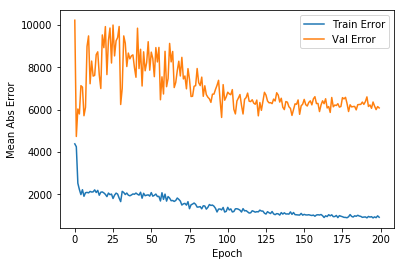

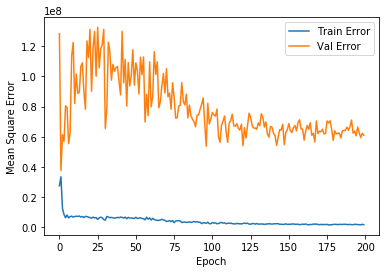

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

test predictions= [ 6836.807   6837.5747  6836.7603 ... 10159.98   12968.633  12631.623 ]


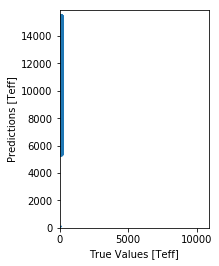

In [34]:
test_predictions = model.predict(norm_flux).flatten()

plt.scatter(normalize(teff), test_predictions)
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

print('test predictions=', test_predictions)